# Nobel Model

Úlohy:
1. Losovat úmrtí
2. Losovat vakcinaci
3. Ty, kde vakcinace - úmrtí <= 14 dnů => nevakcinovat
4. S pravděpodobností P lidi z bodu 3. necháme zemřít


In [59]:
from tqdm.contrib.concurrent import process_map
from matplotlib import pyplot as plt
from common import *

import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
sns.set_theme()

## Load data

In [3]:
df_deaths = pd.read_csv(DEATHS_FILE)
df_vacc = pd.read_csv(VACCINATION_FILE)
df_counts = pd.read_csv(COUNTS_FILE)

### Sanity checks

In [4]:
assert len(df_deaths) >= len(df_vacc.drop(columns="poradi_davky").groupby(["tyden", "vek"]).sum()), "Cropping applied?"
assert len(df_deaths["tyden"].unique()) == len(df_vacc["tyden"].unique()), "Weeks are not the same!"
assert len(df_deaths["vek"].unique()) == len(df_vacc["vek"].unique()) == len(df_counts["vek"].unique()), "Age groups are not the same!"

In [5]:
# We will only use first dose
df_vacc = df_vacc[df_vacc.poradi_davky == 1].drop(columns="poradi_davky")

# Convert weeks to timestamps in seconds
df_vacc["tyden"] = pd.to_datetime(df_vacc["tyden"] + "-1", format="%Y-W%W-%w").astype("int64") // 10**9
df_deaths["tyden"] = pd.to_datetime(df_deaths["tyden"] + "-1", format="%Y-W%W-%w").astype("int64") // 10**9

### Preview

In [6]:
df_deaths

,tyden,vek,umrti
0,1609113600,0-29,24
1,1609113600,30-39,27
2,1609113600,40-49,69
3,1609113600,50-59,168
4,1609113600,60-69,428
...,...,...,...
730,1671408000,30-39,23
731,1671408000,40-49,86
732,1671408000,50-59,150
733,1671408000,60-69,342


In [7]:
df_vacc

,tyden,vek,pocet_davek
0,1609113600,0-29,144
1,1609113600,30-39,233
2,1609113600,40-49,338
3,1609113600,50-59,274
4,1609113600,60-69,183
...,...,...,...
2133,1671408000,70-79,2
2135,1671408000,50-59,13
2138,1671408000,0-29,51
2142,1671408000,30-39,19


In [8]:
df_counts

,vek,celkem
0,0-29,3259827
1,30-39,1409650
2,40-49,1735533
3,50-59,1354501
4,60-69,1284689
5,70-79,1037997
6,80-129,441970


## Preparations

In [9]:
TIMEDELTA = timedelta(weeks=2).total_seconds()

In [65]:
def run(p):
    # Data variables
    people = {}
    total_people = df_counts.celkem.sum()

    # Report counts
    count_vacc_after_death = 0
    count_vacc_timedelta_death = 0

    for row_counts in df_counts.itertuples():
        # Select rows for age group
        dfs_deaths = df_deaths[df_deaths.vek == row_counts.vek]
        dfs_vacc = df_vacc[df_vacc.vek == row_counts.vek]

        # Append None to the end of the array (= no death/vaccination)
        da = np.append(dfs_deaths.tyden, None)
        va = np.append(dfs_vacc.tyden, None)

        # Append count to the end of the array for assignation with da and va (people with no death/vaccination)
        dp = np.append(dfs_deaths.umrti, row_counts.celkem - dfs_deaths.umrti.sum())
        vp = np.append(dfs_vacc.pocet_davek, row_counts.celkem - dfs_vacc.pocet_davek.sum())

        # Normalize (so that the sum is 1), then randomly choice dates of death/vaccination
        dates_death = np.random.choice(da, row_counts.celkem, p=dp / dp.sum())
        dates_vacc = np.random.choice(va, row_counts.celkem, p=vp / vp.sum())

        # print(f"Dead: {len(dates_death[dates_death != None])}/{dfs_deaths.umrti.sum()}")

        # Assign dates for each person
        for n in range(row_counts.celkem):
            date_death = dates_death[n]
            date_vacc = dates_vacc[n]

            if date_vacc is not None and date_death is not None:
                # Invalid assigment
                if date_vacc > date_death:
                    count_vacc_after_death += 1
                    date_vacc = None

                # Modeled 
                elif date_vacc + TIMEDELTA > date_death:
                    if np.random.random() < p:
                        count_vacc_timedelta_death += 1
                        date_vacc = None

            people.setdefault(row_counts.vek, []).append({"dead": date_death, "vaccinated": date_vacc})

    #print(f"Vakcinováno po úmrtí: {count_vacc_after_death}")
    #print(f"Odebráno pro jev {P=}: {count_vacc_timedelta_death}");

    x, y = {}, {}

    for week in np.unique(df_deaths["tyden"]):
        for age, p in people.items():
            deaths_vacc = 0
            deaths_norm = 0
            alive_vacc = 0
            alive_norm = 0

            for i in p:
                if i["dead"] is None or i["dead"] > week:
                    if i["vaccinated"] is None:
                        alive_norm += 1
                    else:
                        alive_vacc += 1

                elif i["dead"] == week:
                    # There is no need to check for bigger than death, it is filtered before
                    if i["vaccinated"] is None:
                        deaths_norm += 1
                    else:
                        deaths_vacc += 1
            
            try:
                efficacy = 1 - (deaths_vacc / alive_vacc) / (deaths_norm / alive_norm)
            except ZeroDivisionError:
                efficacy = -10
            # Report
            x.setdefault(age, []).append(datetime.fromtimestamp(week))
            y.setdefault(age, []).append(efficacy)
    
    return x, y, count_vacc_after_death, count_vacc_timedelta_death

## Simulation

In [66]:
data = process_map(run, [0] * 100, max_workers=os.cpu_count())

  0%|          | 0/100 [00:00<?, ?it/s]

TypeError: list.append() takes exactly one argument (0 given)

## Graphs

### Účinnost

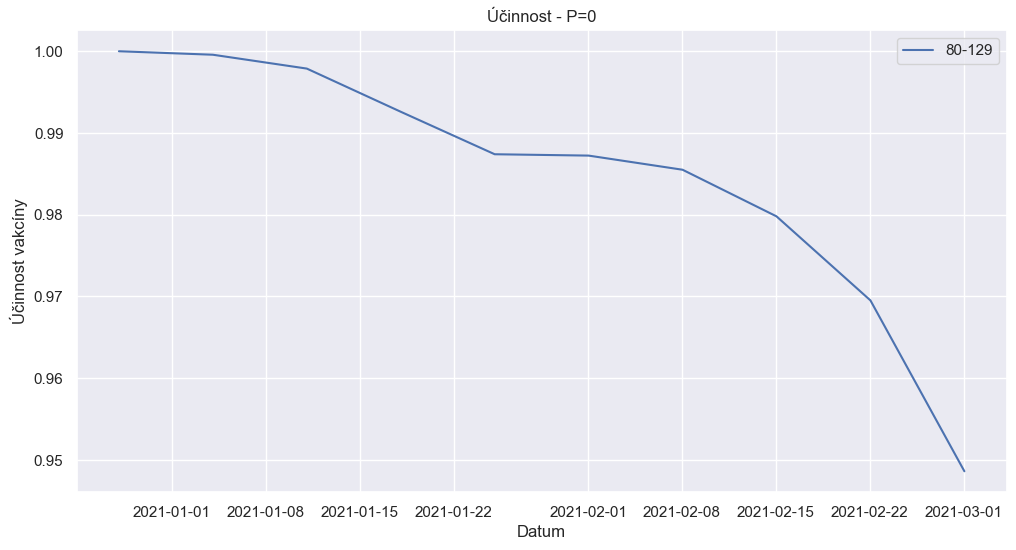

In [56]:
plt.figure(figsize=(12, 6))
for age in list(y.keys())[-1:]:
    plt.plot(x[age], y[age], label=age)

plt.ylabel("Účinnost vakcíny")
plt.xlabel("Datum")
plt.title(f"Účinnost - {P=}")
plt.legend()
plt.savefig(f"result/P_{P}_efficacy.png");